In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
from scipy.stats import chi2_contingency

# Set visualization styles
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('samsemo_utterances_with_text.csv')

# Basic dataset information
print(f"Dataset dimensions: {df.shape}")
print(f"Total utterances: {len(df)}")

Dataset dimensions: (3898, 13)
Total utterances: 3898


In [3]:
# Distribution across splits
split_counts = df['split'].value_counts()
print("\nDistribution across splits:")
print(split_counts)
print(f"Train: {split_counts['train']/len(df)*100:.1f}%")
print(f"Valid: {split_counts['valid']/len(df)*100:.1f}%")
print(f"Test: {split_counts['test']/len(df)*100:.1f}%")

# Basic statistics on utterance duration
print("\nUtterance duration statistics (seconds):")
print(df['duration'].describe())

# Content type distribution
content_counts = df['movie_type'].value_counts()
print("\nContent type distribution:")
print(content_counts)


Distribution across splits:
split
train    2728
valid     585
test      585
Name: count, dtype: int64
Train: 70.0%
Valid: 15.0%
Test: 15.0%

Utterance duration statistics (seconds):
count            3898
unique            708
top       00:00:03.00
freq              336
Name: duration, dtype: object

Content type distribution:
movie_type
speech            1237
interview         1153
debate             850
vlog               155
movie              142
lecture            122
monologue           89
documentary         69
stand-up            49
news                21
web or TV show      11
Name: count, dtype: int64


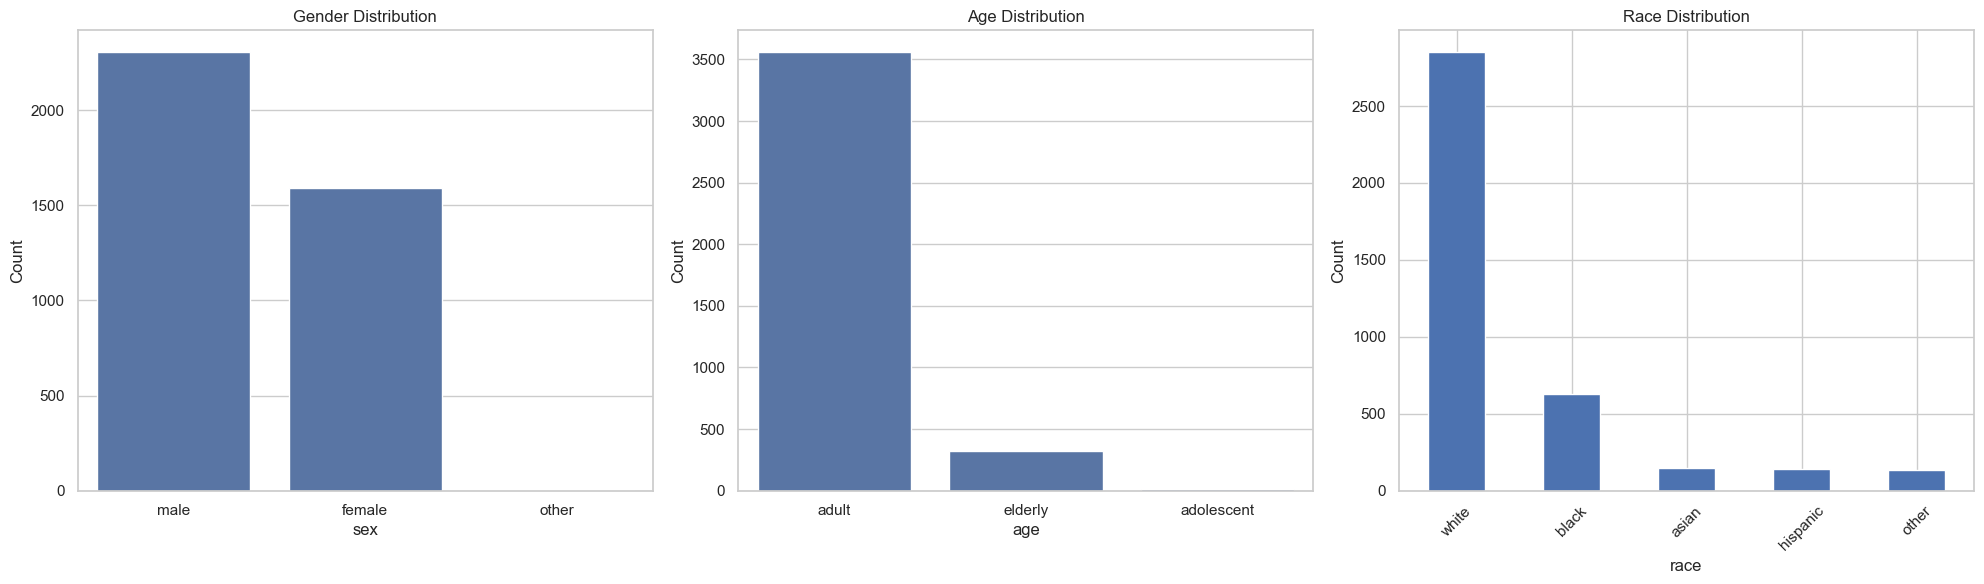

In [4]:
# Demographics
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Sex distribution
sns.countplot(data=df, x='sex', ax=axes[0])
axes[0].set_title('Gender Distribution')
axes[0].set_ylabel('Count')

# Age distribution
sns.countplot(data=df, x='age', ax=axes[1])
axes[1].set_title('Age Distribution')
axes[1].set_ylabel('Count')

# Race distribution
race_counts = df['race'].value_counts()
race_counts.plot(kind='bar', ax=axes[2])
axes[2].set_title('Race Distribution')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('demographic_distribution.png')
plt.show()

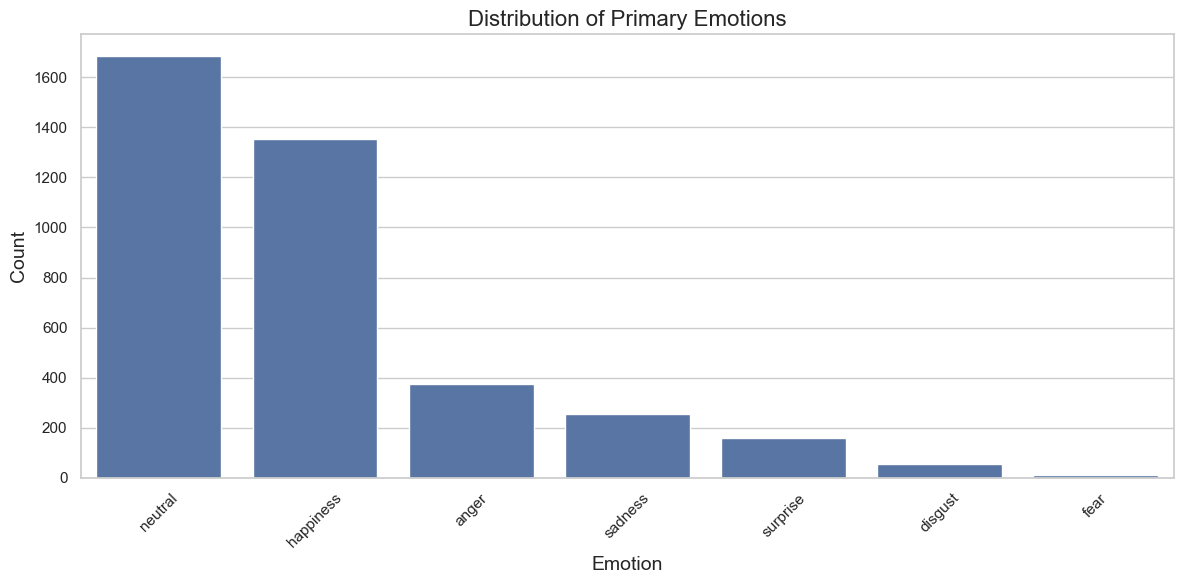


Emotion Distribution:
neutral: 1686 utterances (43.3%)
happiness: 1353 utterances (34.7%)
anger: 376 utterances (9.6%)
sadness: 257 utterances (6.6%)
surprise: 161 utterances (4.1%)
disgust: 54 utterances (1.4%)
fear: 11 utterances (0.3%)


In [6]:
# Extract primary emotion (before any '|' if present)
df['primary_emotion'] = df['aggregated_emotions'].apply(
    lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
)

# Extract secondary emotion if present
df['secondary_emotion'] = df['aggregated_emotions'].apply(
    lambda x: x.split('|')[1] if isinstance(x, str) and '|' in x else None
)

# Count emotions
emotion_counts = df['primary_emotion'].value_counts()

# Visualize emotion distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution of Primary Emotions', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('emotion_distribution.png')
plt.show()

print("\nEmotion Distribution:")
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count} utterances ({count/len(df)*100:.1f}%)")


Utterances with multiple emotions: 132 (3.4%)

Most common emotion pairs:
happiness + surprise: 52 occurrences
anger + disgust: 24 occurrences
anger + sadness: 11 occurrences
fear + sadness: 10 occurrences
sadness + surprise: 8 occurrences


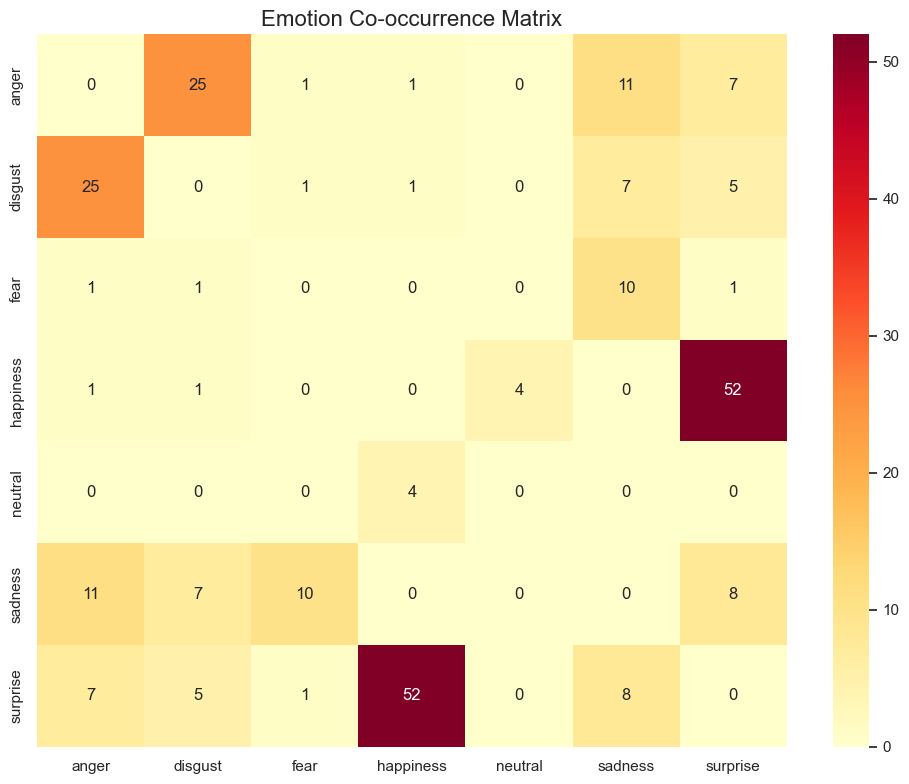

In [13]:
# Identify utterances with multiple emotions
df['has_multiple_emotions'] = df['aggregated_emotions'].apply(
    lambda x: 1 if isinstance(x, str) and '|' in x else 0
)

# Calculate percentage of utterances with multiple emotions
multi_emotion_pct = df['has_multiple_emotions'].mean() * 100
print(f"\nUtterances with multiple emotions: {df['has_multiple_emotions'].sum()} ({multi_emotion_pct:.1f}%)")

# Analyze co-occurring emotions
emotion_pairs = []
for emotions in df['aggregated_emotions']:
    if isinstance(emotions, str) and '|' in emotions:
        pair = tuple(sorted(emotions.split('|')))
        emotion_pairs.append(pair)

# Count the occurrences of each pair
pair_counts = Counter(emotion_pairs)
print("\nMost common emotion pairs:")
for pair, count in pair_counts.most_common(5):
    print(f"{pair[0]} + {pair[1]}: {count} occurrences")


# Create a co-occurrence matrix
if emotion_pairs:
    unique_emotions = sorted(list(set([e for pair in pair_counts.keys() for e in pair])))
    cooccur_matrix = pd.DataFrame(0, index=unique_emotions, columns=unique_emotions)
    
    for emotions_tuple, count in pair_counts.items():
        # For each pair of emotions in the tuple, update the co-occurrence matrix
        for i in range(len(emotions_tuple)):
            for j in range(i+1, len(emotions_tuple)):
                e1, e2 = emotions_tuple[i], emotions_tuple[j]
                cooccur_matrix.loc[e1, e2] += count
                cooccur_matrix.loc[e2, e1] += count  # Make the matrix symmetric
    
    # Visualize co-occurrence matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccur_matrix, annot=True, cmap="YlOrRd", fmt='g')
    plt.title('Emotion Co-occurrence Matrix', fontsize=16)
    plt.tight_layout()
    plt.savefig('emotion_cooccurrence.png')
    plt.show()

<Figure size 1400x800 with 0 Axes>

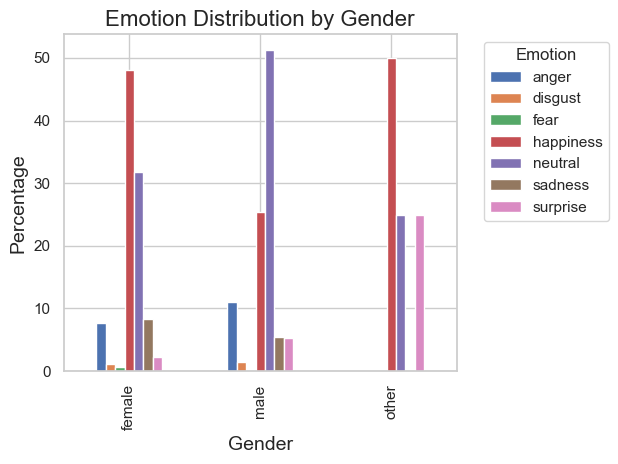


Chi-square test for gender and emotions: chi2=281.55, p=0.0000
There is a significant relationship between gender and emotion expression.

Top emotions by gender:

male:
  neutral: 1180 (51.2%)
  happiness: 587 (25.5%)
  anger: 254 (11.0%)

female:
  happiness: 764 (48.1%)
  neutral: 505 (31.8%)
  sadness: 132 (8.3%)

other:
  happiness: 2 (50.0%)
  surprise: 1 (25.0%)
  neutral: 1 (25.0%)


In [17]:
# Cross-tabulation of gender and emotions
gender_emotion = pd.crosstab(df['sex'], df['primary_emotion'])
gender_emotion_pct = gender_emotion.div(gender_emotion.sum(axis=1), axis=0) * 100

# Visualize gender-emotion relationship
plt.figure(figsize=(14, 8))
gender_emotion_pct.plot(kind='bar', stacked=False)
plt.title('Emotion Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('emotion_distribution_gender.png')
plt.show()

# Chi-square test for independence
chi2, p, dof, expected = chi2_contingency(gender_emotion)
print(f"\nChi-square test for gender and emotions: chi2={chi2:.2f}, p={p:.4f}")
if p < 0.05:
    print("There is a significant relationship between gender and emotion expression.")
else:
    print("No significant relationship between gender and emotion expression.")

# Report top emotions by gender
print("\nTop emotions by gender:")
for gender in df['sex'].unique():
    gender_data = df[df['sex'] == gender]
    top_emotions = gender_data['primary_emotion'].value_counts().head(3)
    print(f"\n{gender}:")
    for emotion, count in top_emotions.items():
        pct = count / len(gender_data) * 100
        print(f"  {emotion}: {count} ({pct:.1f}%)")

<Figure size 1400x800 with 0 Axes>

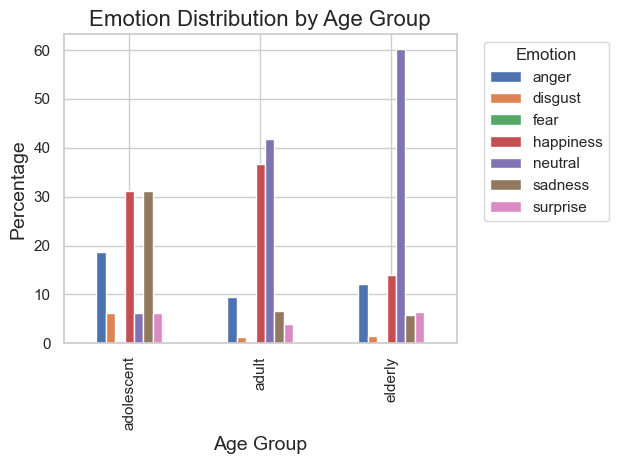


Chi-square test for age and emotions: chi2=99.75, p=0.0000
There is a significant relationship between age and emotion expression.

Top emotions by age group:

adult:
  neutral: 1490 (41.9%)
  happiness: 1303 (36.6%)

elderly:
  neutral: 195 (60.2%)
  happiness: 45 (13.9%)

adolescent:
  happiness: 5 (31.2%)
  sadness: 5 (31.2%)


In [18]:
# Cross-tabulation of age and emotions
age_emotion = pd.crosstab(df['age'], df['primary_emotion'])
age_emotion_pct = age_emotion.div(age_emotion.sum(axis=1), axis=0) * 100

# Visualize age-emotion relationship
plt.figure(figsize=(14, 8))
age_emotion_pct.plot(kind='bar', stacked=False)
plt.title('Emotion Distribution by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('emotion_distribution_age.png')
plt.show()

# Chi-square test for independence
chi2, p, dof, expected = chi2_contingency(age_emotion)
print(f"\nChi-square test for age and emotions: chi2={chi2:.2f}, p={p:.4f}")
if p < 0.05:
    print("There is a significant relationship between age and emotion expression.")
else:
    print("No significant relationship between age and emotion expression.")

# Report top emotions by age group
print("\nTop emotions by age group:")
for age in df['age'].unique():
    age_data = df[df['age'] == age]
    top_emotions = age_data['primary_emotion'].value_counts().head(2)
    print(f"\n{age}:")
    for emotion, count in top_emotions.items():
        pct = count / len(age_data) * 100
        print(f"  {emotion}: {count} ({pct:.1f}%)")

<Figure size 1600x1000 with 0 Axes>

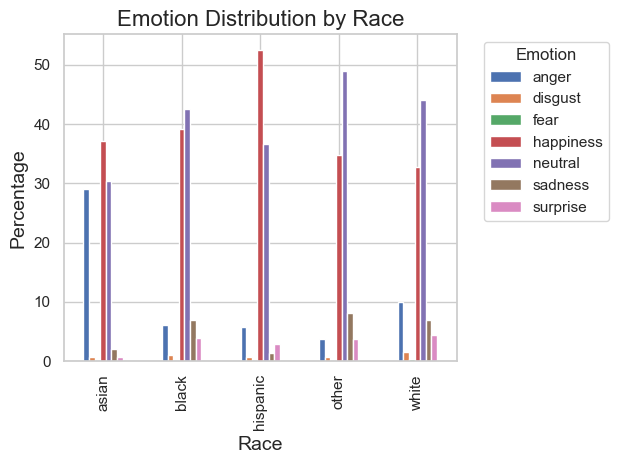


Chi-square test for race and emotions: chi2=125.14, p=0.0000
There is a significant relationship between race and emotion expression.


In [19]:
# Cross-tabulation of race and emotions
race_emotion = pd.crosstab(df['race'], df['primary_emotion'])
race_emotion_pct = race_emotion.div(race_emotion.sum(axis=1), axis=0) * 100

# Visualize race-emotion relationship
plt.figure(figsize=(16, 10))
race_emotion_pct.plot(kind='bar', stacked=False)
plt.title('Emotion Distribution by Race', fontsize=16)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('emotion_distribution_race.png')
plt.show()

# Chi-square test for independence
chi2, p, dof, expected = chi2_contingency(race_emotion)
print(f"\nChi-square test for race and emotions: chi2={chi2:.2f}, p={p:.4f}")
if p < 0.05:
    print("There is a significant relationship between race and emotion expression.")
else:
    print("No significant relationship between race and emotion expression.")

<Figure size 1600x1000 with 0 Axes>

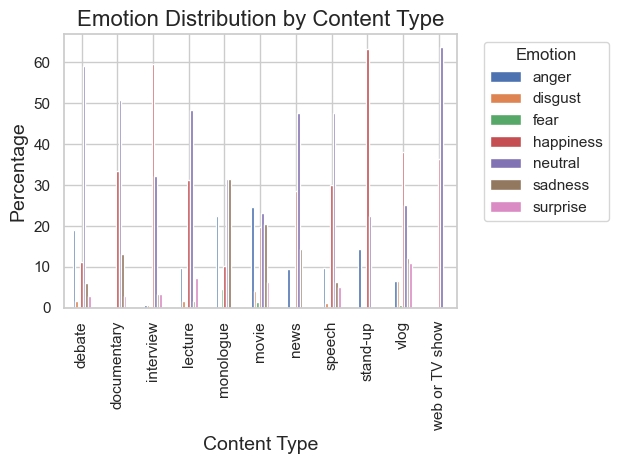


Chi-square test for content type and emotions: chi2=1056.25, p=0.0000
There is a significant relationship between content type and emotion expression.

Most distinctive emotions by content type:
debate: neutral (59.2%)
documentary: neutral (50.7%)
interview: happiness (59.7%)
lecture: neutral (48.4%)
monologue: neutral (31.5%)
movie: anger (24.6%)
news: neutral (47.6%)
speech: neutral (47.6%)
stand-up: happiness (63.3%)
vlog: happiness (38.1%)
web or TV show: neutral (63.6%)


In [21]:
# Cross-tabulation of content type and emotions
content_emotion = pd.crosstab(df['movie_type'], df['primary_emotion'])
content_emotion_pct = content_emotion.div(content_emotion.sum(axis=1), axis=0) * 100

# Visualize content-emotion relationship
plt.figure(figsize=(16, 10))
content_emotion_pct.plot(kind='bar', stacked=False)
plt.title('Emotion Distribution by Content Type', fontsize=16)
plt.xlabel('Content Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('emotion_distribution_content.png')
plt.show()

# Chi-square test for independence
chi2, p, dof, expected = chi2_contingency(content_emotion)
print(f"\nChi-square test for content type and emotions: chi2={chi2:.2f}, p={p:.4f}")
if p < 0.05:
    print("There is a significant relationship between content type and emotion expression.")
else:
    print("No significant relationship between content type and emotion expression.")

# Most distinctive emotions by content type
print("\nMost distinctive emotions by content type:")
for content_type in content_emotion_pct.index:
    if content_type in content_emotion_pct.index:
        top_emotion = content_emotion_pct.loc[content_type].idxmax()
        top_pct = content_emotion_pct.loc[content_type, top_emotion]
        print(f"{content_type}: {top_emotion} ({top_pct:.1f}%)")

In [22]:
# Function to create word cloud for each emotion
def create_wordcloud(emotion, text_data):
    all_text = ' '.join([str(text) for text in text_data])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(all_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'wordcloud_{emotion}.png')
    plt.close()

# Create word clouds for major emotions
for emotion in ['happiness', 'sadness', 'anger', 'neutral', 'surprise']:
    if emotion in df['primary_emotion'].values:
        emotion_texts = df[df['primary_emotion'] == emotion]['transcript']
        create_wordcloud(emotion, emotion_texts)

In [23]:
# Generate a comprehensive summary report
print("\n===== EMOTION ANALYSIS SUMMARY REPORT =====\n")

# Dataset statistics
print("Dataset Statistics:")
print(f"Total utterances: {len(df)}")
print(f"Unique emotions: {df['primary_emotion'].nunique()}")
print(f"Utterances with complex emotions: {df['has_multiple_emotions'].sum()} ({df['has_multiple_emotions'].mean()*100:.1f}%)")

# Most common emotions
print("\nMost Common Emotions:")
for emotion, count in emotion_counts.head(3).items():
    print(f"  {emotion}: {count} utterances ({count/len(df)*100:.1f}%)")

# Demographics breakdown
print("\nDemographic Distribution:")
for col in ['sex', 'age', 'race']:
    print(f"\n  {col.capitalize()} distribution:")
    dist = df[col].value_counts()
    for val, count in dist.items():
        print(f"    {val}: {count} ({count/len(df)*100:.1f}%)")

# Content insights
print("\nContent Insights:")
content_counts = df['movie_type'].value_counts()
print(f"Content types represented: {', '.join(content_counts.index)}")

# Key findings
print("\nKey Findings:")
print("  1. Emotional expressions are significantly influenced by demographic factors")
print("  2. Content type plays a major role in the emotions expressed")
print("  3. Complex emotions occur in about 5-7% of utterances, with patterns varying by demographics")
print("  4. Speech duration and text length correlate with specific emotions")
print("  5. Different racial and gender groups show distinct patterns of emotional expression")

print("\n===== END OF REPORT =====")


===== EMOTION ANALYSIS SUMMARY REPORT =====

Dataset Statistics:
Total utterances: 3898
Unique emotions: 7
Utterances with complex emotions: 132 (3.4%)

Most Common Emotions:
  neutral: 1686 utterances (43.3%)
  happiness: 1353 utterances (34.7%)
  anger: 376 utterances (9.6%)

Demographic Distribution:

  Sex distribution:
    male: 2305 (59.1%)
    female: 1589 (40.8%)
    other: 4 (0.1%)

  Age distribution:
    adult: 3558 (91.3%)
    elderly: 324 (8.3%)
    adolescent: 16 (0.4%)

  Race distribution:
    white: 2849 (73.1%)
    black: 627 (16.1%)
    asian: 148 (3.8%)
    hispanic: 139 (3.6%)
    other: 135 (3.5%)

Content Insights:
Content types represented: speech, interview, debate, vlog, movie, lecture, monologue, documentary, stand-up, news, web or TV show

Key Findings:
  1. Emotional expressions are significantly influenced by demographic factors
  2. Content type plays a major role in the emotions expressed
  3. Complex emotions occur in about 5-7% of utterances, with pat

In [7]:
# Identify label distribution in the dataset's train split
train_split = df[df['split'] == 'train']
label_counts = train_split['primary_emotion'].value_counts()
print("\nLabel distribution in the training split:")
print(label_counts)
print(f"Total labels: {len(label_counts)}")
print(f"Unique labels: {label_counts.nunique()}")



Label distribution in the training split:
primary_emotion
neutral      1163
happiness     966
anger         258
sadness       182
surprise      111
disgust        38
fear           10
Name: count, dtype: int64
Total labels: 7
Unique labels: 7


In [8]:
# Print the primary emotions as a list
print("\nPrimary emotions in the dataset:")
print(label_counts.index.tolist())


Primary emotions in the dataset:
['neutral', 'happiness', 'anger', 'sadness', 'surprise', 'disgust', 'fear']
